In [1]:
import pandas as pd
import numpy as np
import pathlib  

In [31]:
IN_PARQUET = pathlib.Path("data/40_preprocessed/42_mapping/articles.parquet")

In [32]:
df = pd.read_parquet(IN_PARQUET)
df

,article_id,title,linked_article_titles
0,0,april,"[month, year, julian calendar, gregorian calen..."
1,1,august,"[month, year, gregorian calendar, july, septem..."
2,2,art,"[renoir, bowl, craft, artist, emotion, creativ..."
3,3,a,"[letter, alphabet, english language, vowel, di..."
4,4,air,"[earth, atmosphere, mixture, gas, breathe, vol..."
...,...,...,...
375853,375853,drayton manor,[]
375854,375854,theodore roosevelt presidential library,"[medora, north dakota, north dakota, theodore ..."
375855,375855,warren g. harding presidential center,"[presidential library system, warren g. hardin..."
375856,375856,presidential library,[presidential library system]


In [33]:
import pandas as pd
import networkx as nx
import ast  # in case linked_article_titles is stored as a string
from community import community_louvain

# --- Load your DataFrame (replace this with your actual loading code) ---
# Example:
# df = pd.read_csv("your_data.csv")

# Ensure linked_article_titles is a list
df['linked_article_titles'] = df['linked_article_titles'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# --- Build the graph ---
G = nx.Graph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row['title'])

# Add edges (only when linked article exists in the dataset)
article_titles_set = set(df['title'])

for _, row in df.iterrows():
    source = row['title']
    for target in row['linked_article_titles']:
        if target in article_titles_set:  # ensure the target exists
            G.add_edge(source, target)

# --- Run Louvain community detection ---
partition = community_louvain.best_partition(G)

# Add the community assignment to the DataFrame
df['louvain_community'] = df['title'].map(partition)

# Done!
print(df[['title', 'louvain_community']])

# Assign community as a node attribute in the graph
nx.set_node_attributes(G, partition, 'louvain_community')

# Now export
nx.write_gexf(G, "wikipedia_graph_complete.gexf")


                                          title  louvain_community
0                                         april                  0
1                                        august                  0
2                                           art                  1
3                                             a                  2
4                                           air                  1
...                                         ...                ...
375853                            drayton manor                 24
375854  theodore roosevelt presidential library                  6
375855    warren g. harding presidential center                  6
375856                     presidential library                  6
375857      donald j. trump presidential center                  6

[375858 rows x 2 columns]


In [26]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
colors = [partition[node] for node in G.nodes()]

nx.draw(G, pos, node_color=colors, with_labels=False, node_size=30, cmap=plt.cm.Set3)
plt.show()

KeyboardInterrupt: 

In [4]:
import pandas as pd

# Step 1: Extract first-position categories from non-empty lists
first_categories = df['categories'].dropna().apply(lambda x: x[0] if x else None)

# Step 2: Get all unique first-position categories
first_set = set(first_categories.dropna().unique())

# Step 3: Flatten all categories into a set
all_categories = set(cat for row in df['categories'] if row for cat in row)

# Step 4: Subtract to get categories that never appear first
never_first = all_categories - first_set

# Result: A set of categories that never occur first
print(never_first)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the features for clustering

# Exclude the columns you don't want
features = df.drop(columns=['title', 'linked_article_titles', 'categories','sections_count', 'cleaned_article_body', 'char_count', 'word_count',
       'sentence_count', 'avg_word_length', 'avg_sentence_length',
       'uppercase_word_count', 'stopword_ratio', 'punctuation_ratio', 'article_id'])

In [14]:
for i in features.columns:
    print(i, features[i].dtype)

emb_0 float32
emb_1 float32
emb_2 float32
emb_3 float32
emb_4 float32
emb_5 float32
emb_6 float32
emb_7 float32
emb_8 float32
emb_9 float32
emb_10 float32
emb_11 float32
emb_12 float32
emb_13 float32
emb_14 float32
emb_15 float32
emb_16 float32
emb_17 float32
emb_18 float32
emb_19 float32
emb_20 float32
emb_21 float32
emb_22 float32
emb_23 float32
emb_24 float32
emb_25 float32
emb_26 float32
emb_27 float32
emb_28 float32
emb_29 float32
emb_30 float32
emb_31 float32
emb_32 float32
emb_33 float32
emb_34 float32
emb_35 float32
emb_36 float32
emb_37 float32
emb_38 float32
emb_39 float32
emb_40 float32
emb_41 float32
emb_42 float32
emb_43 float32
emb_44 float32
emb_45 float32
emb_46 float32
emb_47 float32
emb_48 float32
emb_49 float32
emb_50 float32
emb_51 float32
emb_52 float32
emb_53 float32
emb_54 float32
emb_55 float32
emb_56 float32
emb_57 float32
emb_58 float32
emb_59 float32
emb_60 float32
emb_61 float32
emb_62 float32
emb_63 float32
emb_64 float32
emb_65 float32
emb_66 float32
emb_6

In [15]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from joblib import Parallel, delayed
from tqdm import tqdm  # Progress bar
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Feature selection and scaling
features = df.drop(columns=['title', 'linked_article_titles', 'categories','sections_count', 'cleaned_article_body', 'char_count', 'word_count',
       'sentence_count', 'avg_word_length', 'avg_sentence_length',
       'uppercase_word_count', 'stopword_ratio', 'punctuation_ratio', 'article_id'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

def evaluate_k(k, data):
    model = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=1000,
        max_iter=100,          # Faster convergence
        tol=1e-4,             # Early stopping
        n_init=3              # Reduce repeated runs
    )
    labels = model.fit_predict(data)
    unique_clusters = len(np.unique(labels))
    
    # Skip metrics if clusters are degenerate
    metrics = {
        'k': k,
        'inertia': model.inertia_,
        'silhouette': np.nan,
        'davies_bouldin': np.nan,
        'n_clusters': unique_clusters
    }
    
    if unique_clusters > 1:  # Metrics require at least 2 clusters
        try:
            metrics['silhouette'] = silhouette_score(data, labels)
        except:
            pass
        try:
            metrics['davies_bouldin'] = davies_bouldin_score(data, labels)
        except:
            pass
    
    return metrics

# Evaluate k in parallel with progress bar
k_values = range(4500, 4601, 1)

# Wrap Parallel execution with tqdm for progress tracking
results = Parallel(n_jobs=-1)(
    delayed(evaluate_k)(k, scaled_features) for k in tqdm(k_values, desc="Evaluating k")
)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Inertia
ax1.plot(results_df['k'], results_df['inertia'], marker='o', color='b')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# Silhouette
ax2.plot(results_df['k'], results_df['silhouette'], marker='o', color='r')
ax2.set_title('Silhouette Score (Higher = Better)')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Score')
ax2.grid(True)

# Davies-Bouldin
ax3.plot(results_df['k'], results_df['davies_bouldin'], marker='o', color='g')
ax3.set_title('Davies-Bouldin Index (Lower = Better)')
ax3.set_xlabel('Number of clusters')
ax3.set_ylabel('Score')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print best k-values
print("\nOptimal k-values:")
print(f"- Best Silhouette: k={results_df.loc[results_df['silhouette'].idxmax(), 'k']}")
print(f"- Best Davies-Bouldin: k={results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']}")

KeyboardInterrupt: 

In [13]:
df['categories']

0                                                  [Months]
1                                                  [Months]
2         [Art, Non-verbal communication, Basic English ...
3                  [Basic English 850 words, Vowel letters]
4                     [Basic English 850 words, Atmosphere]
                                ...                        
375853                                                   []
375854    [Theodore Roosevelt, Buildings and structures ...
375855          [Warren G. Harding, Presidential libraries]
375856                                                   []
375857                                                   []
Name: categories, Length: 375858, dtype: object

In [15]:
# Flatten all category arrays and get unique values
distinct_categories = set(cat for sublist in df['categories'] for cat in sublist)
print(len(distinct_categories))

16419


In [16]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load your data (assuming it's in a DataFrame `df`)
features = df.drop(columns=['title', 'linked_article_titles', 'categories','sections_count', 'cleaned_article_body', 'char_count', 'word_count',
       'sentence_count', 'avg_word_length', 'avg_sentence_length',
       'uppercase_word_count', 'stopword_ratio', 'punctuation_ratio', 'article_id'])

# Standardize features (crucial for DBSCAN)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Run DBSCAN
dbscan = DBSCAN(eps=10, min_samples=15)  # Adjust hyperparameters
clusters = dbscan.fit_predict(scaled_features)

# Add cluster labels to the original DataFrame
df['cluster'] = clusters

# Analyze results
print("Cluster distribution:")
print(pd.Series(clusters).value_counts())

Cluster distribution:
-1    9832
 2      44
 1      44
 4      33
 0      16
 3      16
 5      15
Name: count, dtype: int64


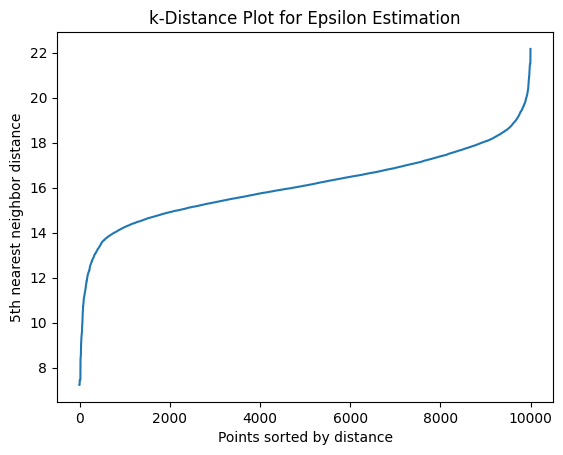

In [17]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

nn = NearestNeighbors(n_neighbors=20)  # k = min_samples
nn.fit(scaled_features)
distances, _ = nn.kneighbors(scaled_features)
distances = np.sort(distances[:, -1])  # Sort the k-th neighbor distances

plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('k-Distance Plot for Epsilon Estimation')
plt.show()